#DATSCI W261, October 2015<br>JRW, HW 5.3-5.4 Walkthrough
##Description
These exercises are relatively formidable tasks with some unexpected details.
So for those of you that would like to continue with this work, here is a walkthrough
on how to accomplish the task.

###Let's first take a look at mrjob.conf
We can use a pretty basic configuration for all of this,
but without multiple instances, we would have to wait a long time
for things to finish.
####cat ~/.mrjob.conf
runners:<Br>
&nbsp;&nbsp;&nbsp;&nbsp;emr:<Br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;aws_access_key_id: XXXX<Br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;aws_secret_access_key: XXXX<Br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;num_ec2_core_instances: 4<Br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ec2_core_instance_type: m1.medium<Br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ec2_master_instance_type: m1.medium<Br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;strict_protocols: true<Br>
&nbsp;&nbsp;&nbsp;&nbsp;hadoop:<Br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;strict_protocols: true<Br>
&nbsp;&nbsp;&nbsp;&nbsp;inline:<Br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;strict_protocols: true<Br>
&nbsp;&nbsp;&nbsp;&nbsp;local:<Br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;strict_protocols: true

##HW 5.3: Do some EDA with the Google 5-grams dataset
###HW 5.3.1: MRJob class to count all words inside of the 5-Grams
This is a basic word count job, where we just total the counts 
of all words inside of all 5-grams. The only real bit of finesse going on here
is with the specification:

    from mrjob.protocol import RawValueProtocol
...

    OUTPUT_PROTOCOL = RawValueProtocol
    
that takes the output protocol to a raw, string value,
so that our output will look nice for the next job
(with no quotes or unnecessary keys or tab characters).

In [185]:
%%writefile count5gramWords.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol
from mrjob.step import MRStep
import re

class count5gramWords(MRJob):
    
    OUTPUT_PROTOCOL = RawValueProtocol

    def steps(self):
        return [MRStep(mapper = self.mapper, combiner = self.combiner, reducer = self.reducer)]
    
    def mapper(self, _, line):
        counts = {}
        line.strip()
        [ngram,count,pages,books] = re.split("\t",line)
        count = int(count)
        words = re.split(" ",ngram)
        for word in words:
            counts.setdefault(word,0)
            counts[word] += count
        for word in counts.keys():
            yield word,counts[word]

    def combiner(self, word, counts):
        yield word,sum(counts)

    def reducer(self, word, counts):
        yield None,word+"\t"+str(sum(counts))

if __name__ == '__main__':
    count5gramWords.run()

Writing count5gramWords.py


In [186]:
!chmod +x count5gramWords.py

####Test the code locally

In [187]:
!./count5gramWords.py gbooks_filtered_sample.txt > count5GramWords_output.txt

using configs in /Users/jakerylandwilliams/.mrjob.conf
creating tmp directory /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/count5gramWords.jakerylandwilliams.20151004.224112.448241
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/count5gramWords.jakerylandwilliams.20151004.224112.448241/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/count5gramWords.jakerylandwilliams.20151004.224112.448241/step-0-mapper-sorted
> sort /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/count5gramWords.jakerylandwilliams.20151004.224112.448241/step-0-mapper_part-00000
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/count5gramWords.jakerylandwilliams.20151004.224112.448241/step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/count5gramWords.jakerylandwilliams.20151004.224112.448241/step-0-reducer_part-00000 -> /var/folders/3y/665

In [188]:
!head -25 count5GramWords_output.txt

A	74206
A's	165
AAR	99
AB	43
ABBREVIATIONS	106
ABC	44
ABD	177
ABM	59
ABOUT	88
ACKNOWLEDGEMENTS	70
ACKNOWLEDGMENTS	79
ACP	110
ACS	49
ACT	73
ADRENAL	43
ADVENTURES	156
AG	111
AH	52
AI	104
AJA	106
AL	97
ALEXANDER	199
ALL	68
ALSO	88
ALWAYS	46


####Run the job on AWS over the full dataset
Note: With the jobconf as above (4 m1.medium instances) this word count job takes about 1 hour. Here, we don't perform any sorting, and since we have specified multiple instances while not restricted the number of reduce tasks,
there will be multiple output parts in our output directory: 

    s3://ucb-mids-mls-jakewilliams/count5gramWords/output/

In [189]:
!./count5gramWords.py s3://filtered-5grams/ -r emr \
    --output-dir=s3://ucb-mids-mls-jakewilliams/count5gramWords/output \
    --no-output 

using configs in /Users/jakerylandwilliams/.mrjob.conf
using existing scratch bucket mrjob-070799b65f5ef217
using s3://mrjob-070799b65f5ef217/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/count5gramWords.jakerylandwilliams.20151004.224737.259694
writing master bootstrap script to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/count5gramWords.jakerylandwilliams.20151004.224737.259694/b.py
Copying non-input files into s3://mrjob-070799b65f5ef217/tmp/count5gramWords.jakerylandwilliams.20151004.224737.259694/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-3BVTJYDNIGURO
Created new job flow j-3BVTJYDNIGURO
Job launched 34.4s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 70.8s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 105.7s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 141.8s ago, status STARTING: Prov

###MRJob class to collect and sort all count output from the above
Here, we'll just pull in the output from the above and pass it through a mapper that is
*almost* the identity mapper, with the distinction that we pass the counts of words as the keys.
This coupled with a reverse numeric sort and single reduce task specification
(in the def jobconf(): method)
will ensure that the ouput appears sorted (frequent to infrequent) and in one file.
Once again, since we are storing our output on disk, and not streaming back to a runner,
we use the RawValueProtocol to ensure a nice clean output.

In [195]:
%%writefile collectAndSortWordCounts.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol
from mrjob.step import MRStep
import re

class collectAndSortWordCounts(MRJob):
    
    OUTPUT_PROTOCOL = RawValueProtocol
    
    def jobconf(self):
        orig_jobconf = super(collectAndSortWordCounts, self).jobconf()        
        custom_jobconf = {
            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapred.text.key.comparator.options': '-k1rn',
            'mapred.reduce.tasks': '1',
        }
        combined_jobconf = orig_jobconf
        combined_jobconf.update(custom_jobconf)
        self.jobconf = combined_jobconf
        return combined_jobconf
    
    def steps(self):
        return [MRStep(mapper = self.mapper, reducer = self.reducer)]
    
    def mapper(self, _, line):
        line.strip()
        [word,count] = re.split("\t",line)
        count = int(count)
        yield count,word

    def reducer(self, count, words):
        for word in words:
            yield None,word+"\t"+str(count)

if __name__ == '__main__':
    collectAndSortWordCounts.run()

Overwriting collectAndSortWordCounts.py


In [196]:
!chmod +x collectAndSortWordCounts.py

####Test the code locally on a sample of output

In [197]:
!./collectAndSortWordCounts.py count5GramWords_output.txt > collectAndSortWordCounts_output.txt

using configs in /Users/jakerylandwilliams/.mrjob.conf
creating tmp directory /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/collectAndSortWordCounts.jakerylandwilliams.20151005.012308.694617
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/collectAndSortWordCounts.jakerylandwilliams.20151005.012308.694617/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/collectAndSortWordCounts.jakerylandwilliams.20151005.012308.694617/step-0-mapper-sorted
> sort /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/collectAndSortWordCounts.jakerylandwilliams.20151005.012308.694617/step-0-mapper_part-00000
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/collectAndSortWordCounts.jakerylandwilliams.20151005.012308.694617/step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/collectAndSortWordCounts.jakerylandwilliams.20151005.012308.6

####Examine the output
Note: Since we are running the job locally, our sort will not work!

In [198]:
!head -25 collectAndSortWordCounts_output.txt

Afterwards	100
Boke	100
Copper	100
Cry	100
Devonian	100
Diet	100
Elyot's	100
Everyone	100
Hymn	100
Kensington	100
Portuguese	100
Thy	100
Traditional	100
ascended	100
awake	100
background	100
bestrode	100
commencement	100
dressing	100
echocardiographic	100
fish	100
latest	100
limitations	100
observe	100
pursuits	100


####Run the job with AWS EMR
Note: With the above configuration in ~/.mrjob.conf, this job takes about 10 minutes (the input data is relatively small).

In [199]:
!./collectAndSortWordCounts.py s3://ucb-mids-mls-jakewilliams/count5gramWords/output/ -r emr \
    --output-dir=s3://ucb-mids-mls-jakewilliams/collectAndSortWordCounts/output \
    --no-output 

using configs in /Users/jakerylandwilliams/.mrjob.conf
using existing scratch bucket mrjob-070799b65f5ef217
using s3://mrjob-070799b65f5ef217/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/collectAndSortWordCounts.jakerylandwilliams.20151005.012342.262994
writing master bootstrap script to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/collectAndSortWordCounts.jakerylandwilliams.20151005.012342.262994/b.py
Copying non-input files into s3://mrjob-070799b65f5ef217/tmp/collectAndSortWordCounts.jakerylandwilliams.20151005.012342.262994/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-1Q4HNGNWNKQXH
Created new job flow j-1Q4HNGNWNKQXH
Job launched 30.9s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 61.9s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 92.8s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 124.4s 

####Download word count data and check on output
Here we can see the totalled word counts are quite large, and that the top of the list
is filled with stop words:

    http://www.ranks.nl/stopwords

If we wanted to proceed with a more nuanced approach 
we could perhaps convert all to lower-case and merge,
and then consult the (referenced) 
list of stop words and take those top 10,000 off the list. 

In [200]:
!aws s3 cp s3://ucb-mids-mls-jakewilliams/collectAndSortWordCounts/output/part-00000 ./sortedWordCounts.txt

download: s3://ucb-mids-mls-jakewilliams/collectAndSortWordCounts/output/part-00000 to ./sortedWordCounts.txt


In [201]:
!head -25 sortedWordCounts.txt

the	5375699242
of	3691308874
to	2221164346
in	1387638591
a	1342195425
and	1135779433
that	798553959
is	756296656
be	688053106
as	481373389
was	469941121
for	454742998
it	426786974
not	398897768
with	372888370
on	351850709
by	344380381
have	316710855
he	288925226
which	281528146
his	263185718
at	260409177
had	256489364
I	255205575
are	247721045


###Plot our data

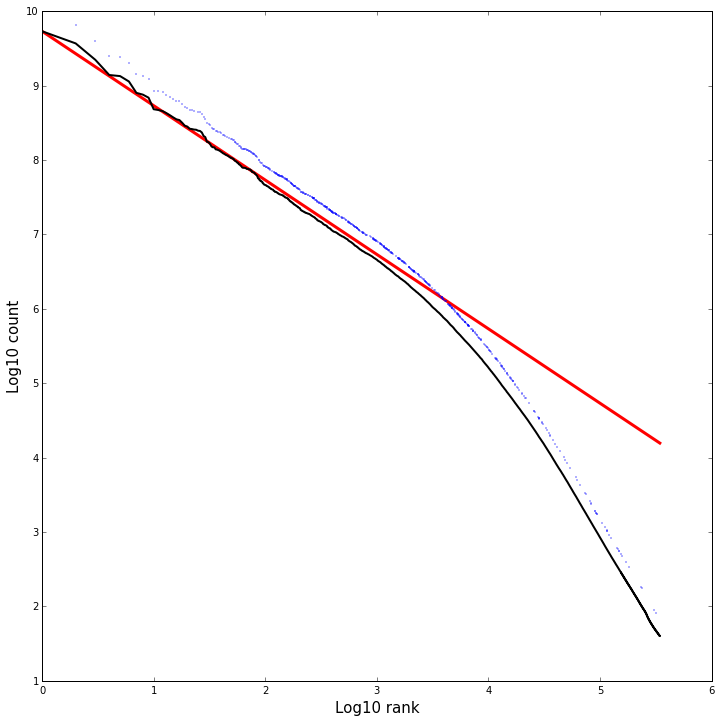

In [23]:
from matplotlib import pyplot as plot
import re,math
%matplotlib inline

ranks = []
counts = []
stopWords = {}
stopRanks = []
stopCounts = []

f = open("stopWords.txt","r")
for word in f:
    word = word.strip()
    stopWords[word] = 1

rank = 1
f = open("sortedWordCounts.txt","r")
for line in f:
    line.strip()
    word,count = re.split("\t",line)
    count = int(count)
    if word in stopWords.keys():
        stopRanks.append(math.log(rank,10))
        stopCounts.append(math.log(count,10)+0.25)
    ranks.append(math.log(rank,10))
    counts.append(math.log(count,10))
    rank += 1
    
rnge = [min(ranks),max(ranks)]
b = max(counts)
m = -1
lin = [rnge[0]*m + b,rnge[1]*m + b]

plot.figure(figsize=(12,12))

plot.subplot(1,1,1)
plot.plot(rnge,lin,'red',lw=3)
plot.plot(ranks,counts,'black',lw=2)
plot.plot(stopRanks,stopCounts,'.',ms=1.25)
plot.xlabel('Log10 rank',fontsize=15)
plot.ylabel('Log10 count',fontsize=15)

Looking above, in log-log space, we compare a plot of our word-frequency distribution to Zipf's law for frequencies (counts) and ranks:

$$\large f\propto r^{-1}$$

This 'law' of ranks is considered by some to be universal 
for natural language, and in log-log space appears as a straight line
of slope -1. Comparing Zipf's law (red) to our empirical word
frequency distribution from the Google 5-grams,
we can see that the two diverge quite significantly
after about three orders of magnitude (1,000 words),
with the empirical word-frequency distribution dropping off
to what appears like another power-law of steeper slope.
Other important observations include the fact that we
do not see the the full tail of our word-frequency distribution,
which consists of the plateaux legomena, finite-size effects:

    https://en.wikipedia.org/wiki/Hapax_legomenon
    
This is because the construction of the Google 5-grams corpus
was predicated on an Apriori-style threshold of minimum count,
set at 40 for 5-grams in the initial dataset.

In addition to all of this, we present the counts of the stopwords 
(blue, offset for clarity). Although these words appear across the
full range of ranks, we can visually inspect to see that their
density diminishes at the larger ranks toward the tail.

##HW 5.4: Synonym detection
####Making the top 10,000 words broadcast file

Next up we will take this output and keep the top 10,000 words to broadcast to the mappers
of the next stripe-producing job. To accomplish this we can use the following 
sequence of command line utilities:

    head -10000 sortedWordCounts.txt | perl -pe 's/^(.*?)\t(.*?)\n/$1\n/' > top10kwords.txt
    
which we have run outside of this notebook. In particular, head takes the top 10,000 lines,
and perl strips off the column of counts, leaving only the words so as to minimize the overhead of
beaming up and loading in the broadcast file.

###HW 5.4.1: MRJob class to produce a co-occurrence count matrix (stripes) for the top 10,000 most frequently appearing words
This is the first truly major task of this assignment, where we have to produce co-occurrence stripes
for our top 10,000 words. The design is relatively straightforward, but as our first major task,
this will take some time to run on AWS when applied to the full dataset.
Using the setup showing in ~/.mrjob.conf above (4 m1.medium instances),
this job takes about 4 hours to run.

In [ ]:
%%writefile stripeCoOccurrences.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol
from mrjob.step import MRStep
import re
from itertools import combinations

class stripeCoOccurrences(MRJob):
    
    OUTPUT_PROTOCOL = RawValueProtocol
    topOcurringWordsDictionary = []

    def steps(self):
        return [MRStep(
                mapper_init = self.mapper_init,
                mapper = self.mapper, 
                combiner = self.combiner, 
                reducer_init = self.reducer_init,                
                reducer = self.reducer
            )]
    
    ## pull in the top occurring words dictionary here for the mapper
    def mapper_init(self):
        f = open("top10kWords.txt","r")
        for word in f:
            word = word.strip()
            self.topOcurringWordsDictionary.append(word)
    
    ## the mapper here will take each 5-gram, turn it into a list of words,
    ## and find all 2-set combinations for which each individual word appears
    ## in the top occurring words dictionary. If such a pair makes the list,
    ## we will take the count of the 5-gram and add it to stripes for both
    ## (word1,word2) and (word2,word1) pairs.
    def mapper(self, _, line):
        counts = {}
        line.strip()
        [ngram,count,pages,books] = re.split("\t",line)
        count = int(count)
        words = re.split(" ",ngram)
        combs = list(combinations(words,2))
        for combination in combs:
            word1,word2 = combination
            if word1 in self.topOcurringWordsDictionary and word2 in self.topOcurringWordsDictionary:
                counts.setdefault(word1,{})
                counts[word1].setdefault(word2,0)
                counts[word1][word2] += count
                counts.setdefault(word2,{})
                counts[word2].setdefault(word1,0)
                counts[word2][word1] += count
        for word in counts.keys():
            yield word,counts[word]
            
    ## The stripes output by the mapper are really only going on
    ## at the record level (indiviual lines/5-grams), so we are 
    ## not really utilizing the full power of stripes there.
    ## However, we are able to make full use of the pattern,
    ## partially aggregating here in the combiner, and then totally
    ## below in the reducer.
    def combiner(self, word, values):
        counts = {}
        for stripe in values:
            for coword in stripe.keys():
                counts.setdefault(coword,0)
                counts[coword] += stripe[coword]
        yield word,counts
        
    def reducer_init(self):
        f = open("top10kWords.txt","r")
        for word in f:
            word = word.strip()
            self.topOcurringWordsDictionary.append(word)
            
    ## Like the combiner we're merging our intermediate stripe outputs,
    ## and will here produce completely aggregated stripes, that we will output.
    ## Abstractly, this looks like:
    ## 
    ## stripeA = {coword1: cocountA1, coword2: cocountA2, ...}
    ## stripeB = {coword1: cocountB1, coword2: cocountB2, ...}
    ## ...
    ## += mergeStripe = {coword1: cocountA1+cocountB1+..., coword2: cocountA2+cocountB2..., ...}
    
    def reducer(self, word, values):
        counts = {}
        for stripe in values:
            for coword in stripe.keys():
                counts.setdefault(coword,0)
                counts[coword] += stripe[coword]
        for coword in self.topOcurringWordsDictionary:
            counts.setdefault(coword,0)
        countList = list(str(counts[coword]) for coword in sorted(self.topOcurringWordsDictionary))
        countStr = ",".join(countList)
        yield None,word+","+countStr

if __name__ == '__main__':
    stripeCoOccurrences.run()

In [225]:
!chmod +x stripeCoOccurrences.py

####Test the code local on sample data.

In [226]:
!./stripeCoOccurrences.py gbooks_filtered_sample.txt \
--file top10kWords.txt \
> stripeCoOccurrences_output.txt

using configs in /Users/jakerylandwilliams/.mrjob.conf
creating tmp directory /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/stripeCoOccurrences.jakerylandwilliams.20151005.064611.512043
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/stripeCoOccurrences.jakerylandwilliams.20151005.064611.512043/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/stripeCoOccurrences.jakerylandwilliams.20151005.064611.512043/step-0-mapper-sorted
> sort /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/stripeCoOccurrences.jakerylandwilliams.20151005.064611.512043/step-0-mapper_part-00000
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/stripeCoOccurrences.jakerylandwilliams.20151005.064611.512043/step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
Moving /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/stripeCoOccurrences.jakerylandwilliams.20151005.064611.512043/step-0-reducer_part-0000

####Check on output.
Note: This is just the output of our local test (200 words, from a small test file),
but we can see already that the dense representation (explicitly showing every number)
is wasting a lot of space with all of those zeros. While this representation 
is convenient for what we will have to develop in the next part, it will not scale well
if we wanted to correlate arbitrary number of words!

In [227]:
!head -2 stripeCoOccurrences_output.txt

A,180,180,0,0,0,0,0,0,0,0,70,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,162,162,0,0,0,0,0,0,336,336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,237,237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,76,76,0,0,0,0,0,0,111,111,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1426,1426,0,0,0,0,0,0,0,0,48,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52,52,0,0,0,0,0,0,249,249,0,0,0,0,0,0,0,0,0,0,0,0,500,500,0,0,0,0,0,0,0,0,0,0,0,0,252,252,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,147,147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,46,0,0,0,0,0,0,0,0,62,62,0,0,0,0,0,0,0,0,0,0,48,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,215,

####Run MRJob class for 10,000 words with the full dataset on AWS from the command line.

In [230]:
!./stripeCoOccurrences.py s3://filtered-5grams/ -r emr \
    --output-dir=s3://ucb-mids-mls-jakewilliams/stripeCoOccurrences/output \
    --no-output \
    --file top10kWords.txt 

using configs in /Users/jakerylandwilliams/.mrjob.conf
using existing scratch bucket mrjob-10df70dfe3ada1f0
using s3://mrjob-10df70dfe3ada1f0/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/stripeCoOccurrences.jakerylandwilliams.20151005.074932.953983
writing master bootstrap script to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/stripeCoOccurrences.jakerylandwilliams.20151005.074932.953983/b.py
Copying non-input files into s3://mrjob-10df70dfe3ada1f0/tmp/stripeCoOccurrences.jakerylandwilliams.20151005.074932.953983/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-1SEQJNR6IS92H
Created new job flow j-1SEQJNR6IS92H
Job launched 30.9s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 62.9s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 93.8s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 125.2s ago, status STA

####Download and inspect a sample of the output

In [231]:
!aws s3 cp s3://ucb-mids-mls-jakewilliams/stripeCoOccurrences/output/part-00000 stripe-1.txt

download: s3://ucb-mids-mls-jakewilliams/stripeCoOccurrences/output/part-00000 to ./stripe-1.txt


In [232]:
!head -2 stripe-1.txt

AIDS,482,0,0,5624,0,67,0,0,0,0,0,0,0,0,0,155,0,0,0,0,0,0,0,0,0,0,52,0,1937,322,0,0,755,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,644,90,0,58,0,0,0,291,0,0,0,0,0,0,0,0,0,0,0,0,0,92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87,47,0,0,64,0,0,0,0,0,1736,0,0,0,0,0,0,0,130,0,0,0,0,107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87,0,45,0,0,0,0,132,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,366,0,0,0,217,0,0,0,0,0,0,0,0,0,2131,0,0,0,0,0,0,0,55,0,0,0,0,0,0,0,0,0,0,0,251,0,0,0,0,0,0,0,0,0,0,0,0,71,0,0,0,1800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,659,0,0,62,0,0,0,0,0,0,0,83,0,0,0,0,0,0,0,4831,0,0,0,0,0,0,0,0,0,76,0,0,0,0,223,0,71,0,0,0,0,75,0,0,0,0,0,0,0,0,0,0,359,0,0,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,0,0,0,0,0,63,54,0,0,0,0,0,0,0,0,0,155,0,0,0,0,0,0,0,0,0,0,0,0,101,442,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,236,0,0,0,0,0,130,0,0,893,0,0,61,0,0,0,0,0,0,0,0,0,0,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

###HW 5.4.2: MRJob class to run spearman correlations, pairwise on the rows of output of the above.

This task (or any, for pairwise comparisons) is deceptively difficult to parallelize.
What we would like to do is take each of the 10,000 choose 2 (~50,000,000) pairs of rows in our
matrix of stripes, and run our association measure. If we would like to go through these *pairs*
one at a time, however, we would have to replicate (or read) each our stripe-rows 9,999 times,
and more or less (less, really) square the number of copies of our data. This is not a scalable approach.

To think about how we might scale pairwise comparisons, let's take a look at one association metric in specific,
the Spearman correlation coefficient:

    https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient

This association measure is non-parametric and since it is entirely based on data ranks,
is capable of identifying monotonic associations of any variety, i.e., linear and non-linear. 
Supposing we have two vectors of data that we would like to compare
(for brevity we will use $N=10,000$):

$$\large x = (x_1,x_2,\cdots,x_N)\hspace{15pt}\text{ and }\hspace{15pt}y = (y_1,y_2,\cdots,y_N)$$

We must first compute ranks (low to high):

$$\large r_x = (r_{x,1},r_{x,2},\cdots,r_{x,N})\hspace{15pt}\text{ and }\hspace{15pt}r_y = (r_{y,1},r_{y,2},\cdots,r_{y,N})$$

so that we can then compute their differences: 

$$\large d_i = r_{x,i} - r_{y,i}$$

The spearman correlation is then computed as:

$$\large \rho = 1 - \frac{6\sum_{i=1}^Nd_i^2}{N(N^2-1)}$$

So, to proceed we have to determine which operations are associative---we can distribute the summation, 
but to do so we'll have to compute the differences ahead of time. However, to distribute the computation
of the differences, a task will have to have knowledge of all ranks for a particular *column*.
So for our first mapper we will have to:

1. Read a stripe of data:
        word,cocount_1,cocount_2, ...
    
2. Compute ranks of the co-occurrence counts:
        rank_1,rank_2, ...
    
3. Output each i-rank in the format:
        yield i, [word,rank_i]
        
With this first mapper's output (we're transposing the data), we can now design our first reducer:

1. Read in a column (here, column m) of ranks:
        m [rank_{1,m},rank_{2,m}, ..., rank_{N,m}]
2. In some fixed ordering, take the differences of ranks between the 10,000 choose 2 pairs of rows:
        for i in range(N-1):
            diffs = []
            for j in range(N):
                if j > i:
                    pair = words[i]+","+words[j]
                    diff = ranks[i] - ranks[j]
                    diffs.append(diff)
            yield i, diffs
Question: Why do we yield only the partial list of differences, for each row with i as a key?

The output of this first MRStep are our differences of ranks, 
organized such that each holds $\leq N-1$ differences, 
that need to be aggregated across all records having the key i.
So for this (second) step we  will just have a reducer:

1. Component-wise sum up the squares of differences across all records of the same key.
2. Complete the mathematical expression to produce the correlation and 

        yield correlation, pair

Note that we have used the correlation as a key so that we can rank (sort) our correlations
with another reduce-only MRStep:

1. Switch to a reverse numeric sort on the keys
2. Use the identity mapper (none) to pass (k,v) pairs through the shuffle and from the reducer

        yield pair, correlation


In [159]:
%%writefile correlateCoOccurrences.py
#!/usr/bin/python
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol,JSONProtocol
import re
from itertools import combinations

class correlateCoOccurrences(MRJob):

    OUTPUT_PROTOCOL = RawValueProtocol    
    N = 10000
    
    ## a custom jobconf for the final reduce, numeric sort step
    sortconf = {
        'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
        'mapred.text.key.comparator.options': '-k1rn',
        'mapred.reduce.tasks': '1',
    }
    
    ## three steps here
    def steps(self):
        return [MRStep(
                mapper = self.mapper, 
                reducer = self.reducer_differences
            ),
                MRStep(
                mapper_init = self.mapper_init_aggregation,
                reducer_init = self.reducer_init_aggregation,
                reducer = self.reducer_aggregation
            ),
                MRStep(
                mapper_init = self.mapper_init_sort,
                reducer = self.reducer_sort,
                jobconf = self.sortconf
            )]
    
    ## Step 1 mapper: ranks the data, and transposes by using the column (i) as key
    def mapper(self, _, line):
        data = re.split(",",line)
        word = data[0]
        counts = [int(data[i+1]) for i in range(len(data)-1)]
        ranks = sorted(range(len(counts)), key=lambda k: counts[k])
        for i in range(len(ranks)):
            rank = ranks[i]
            yield str(i).zfill(5),[word,rank]
            
    ## Step 1 reducer: collects the ranks for a column, 
    ## and computed N choose 2 differences, 
    ## yielding the differences in lists for those pairs having
    ## the same common first word
    def reducer_differences(self,colNum,values):
        corNum = 0
        ranks = []
        words = []
        for value in values:
            word,rank = value
            ranks.append(rank)
            words.append(word)
        sortIDX = sorted(range(self.N), key=lambda k: words[k])
        for i in range(self.N-1):
            diffs = []
            for j in range(self.N):
                if j > i:
                    diff = (float(ranks[sortIDX[i]]) - float(ranks[sortIDX[j]]))**2
                    diffs.append(diff)
                    corNum += 1
            yield i,diffs
    
    ## Step 2 mapper init: we have set the input protocol to JSON 
    ## for the (default, unspecified) identity mapper!
    def mapper_init_aggregation(self):
        self.INPUT_PROTOCOL = JSONProtocol
    
    ## Step 2 reducer init: It will help in our reducer to have the 
    ## alphabetically sorted list of 10,000 words
    def reducer_init_aggregation(self):
        self.words = []
        f = open("top10kWords.txt","r")
        for word in f:
            word = word.strip()
            self.words.append(word)
    
    ## Step 2 reducer: This reducer is responsible for aggregating 
    ## the differences for each correlation, computing the final
    ## correlation values, and yielding them (as keys) with the word,word pairs.
    def reducer_aggregation(self,i,values):
        correlations = []
        for j in range(self.N):
            if j > i:
                correlations.append(0)
        for diffs in values:
            correlations = [correlations[j] + diffs[j] for j in range(len(correlations))]
        for j in range(len(correlations)):
            correlation = 1-(6*correlations[j]/float(self.N*(self.N**2 - 1)))
            pair = self.words[i]+","+self.words[j+i+1]
            yield correlation,pair
            
    ## Step 3 mapper init: we have set the input protocol to JSON 
    ## for the (default, unspecified) identity mapper!
    def mapper_init_sort(self):
        self.INPUT_PROTOCOL = JSONProtocol

    ## Step 3 reducer: all we're doing is yielding our 10,000 choose 2
    ## sorted correlations, with None as key, since we are using the RawValueProtocol
    def reducer_sort(self,correlation,pairs):
        for pair in pairs:
            yield None,pair+"\t"+str(correlation)

if __name__ == '__main__':
    correlateCoOccurrences.run()

Overwriting correlateCoOccurrences.py


In [160]:
!chmod +x correlateCoOccurrences.py

####Run the the class with N=200 on a test (since modified) locally.

In [156]:
!correlateCoOccurrences.py coocurrence_output.txt --file top2hWords.txt > correlations_output-2.txt

using configs in /Users/jakerylandwilliams/.mrjob.conf
creating tmp directory /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/correlateCoOccurrences.jakerylandwilliams.20151007.005225.462908
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/correlateCoOccurrences.jakerylandwilliams.20151007.005225.462908/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/correlateCoOccurrences.jakerylandwilliams.20151007.005225.462908/step-0-mapper-sorted
> sort /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/correlateCoOccurrences.jakerylandwilliams.20151007.005225.462908/step-0-mapper_part-00000
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/correlateCoOccurrences.jakerylandwilliams.20151007.005225.462908/step-0-reducer_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/correlateCoOccurrences.jakerylandwilliams.20151007.005225.462908/st

####Check on the output.
Note: This was run local, producing a string sort on the numbers,
resulting in a forward numeric sort that we can leverage with the command line
"tail" to see the "top" 25 correlations.

In [157]:
!tail -25 correlations_output-2.txt

Press,liberty	0.951631290782
Medical,Negro	0.951673291832
Negro,results	0.952672316808
liberty,meeting	0.953930848271
Negro,meeting	0.953993849846
ought,results	0.955583889597
meeting,reading	0.957530938273
dream,struck	0.957566939173
reading,results	0.957722943074
liberty,struck	0.958138453461
University,de	0.960310507763
Negro,ought	0.961587039676
Medical,fine	0.963351083777
ought,reading	0.963934598365
meeting,results	0.96444761119
Cairo,struck	0.967018675467
commandment,struck	0.969538738468
liberty,results	0.974766369159
Negro,liberty	0.974860871522
Press,struck	0.97666241656
Medical,ought	0.980229505738
fine,ought	0.981974049351
Press,commandment	0.993695342384
Cairo,Press	0.99560039001
Cairo,commandment	0.997973449336


####Run the the class with a N=200 test (since modified) on AWS, then check the output.

In [143]:
!correlateCoOccurrences.py s3://ucb-mids-mls-jakewilliams/coocurrence_output.txt -r emr \
    --output-dir=s3://ucb-mids-mls-jakewilliams/correlateCoOccurrences-test/output \
    --no-output \
    --file top2hWords.txt 

using configs in /Users/jakerylandwilliams/.mrjob.conf
using existing scratch bucket mrjob-03e94e1f06830625
using s3://mrjob-03e94e1f06830625/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/correlateCoOccurrences.jakerylandwilliams.20151006.233825.612051
writing master bootstrap script to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/correlateCoOccurrences.jakerylandwilliams.20151006.233825.612051/b.py
Copying non-input files into s3://mrjob-03e94e1f06830625/tmp/correlateCoOccurrences.jakerylandwilliams.20151006.233825.612051/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-3U06D7F1V0NIW
Created new job flow j-3U06D7F1V0NIW
Job launched 31.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 62.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 93.8s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 124.9s ago, s

####Check on the output.
Note: The top 25 correlations are actually the "top" 25 (the sort worked on AWS).

In [144]:
!aws s3 cp s3://ucb-mids-mls-jakewilliams/correlateCoOccurrences-test/output/part-00000 \
    ./correlations_output-1.txt

download: s3://ucb-mids-mls-jakewilliams/correlateCoOccurrences-test/output/part-00000 to ./correlations_output-1.txt


In [145]:
!head -25 correlations_output-1.txt

Cairo,commandment	0.997973449336
Cairo,Press	0.99560039001
Press,commandment	0.993695342384
fine,ought	0.981974049351
Medical,ought	0.980229505738
Press,struck	0.97666241656
Negro,liberty	0.974860871522
liberty,results	0.974766369159
commandment,struck	0.969538738468
Cairo,struck	0.967018675467
meeting,results	0.96444761119
ought,reading	0.963934598365
Medical,fine	0.963351083777
Negro,ought	0.961587039676
University,de	0.960310507763
liberty,struck	0.958138453461
reading,results	0.957722943074
dream,struck	0.957566939173
meeting,reading	0.957530938273
ought,results	0.955583889597
Negro,meeting	0.953993849846
liberty,meeting	0.953930848271
Negro,results	0.952672316808
Medical,Negro	0.951673291832
Press,liberty	0.951631290782


####Run the class with full dataset on AWS and check the output.
Note: This is still running---17 hours on 8 c1.xlarge instances...

In [ ]:
!correlateCoOccurrences.py s3://ucb-mids-mls-jakewilliams/stripeCoOccurrences/output/ -r emr \
    --output-dir=s3://ucb-mids-mls-jakewilliams/correlateCoOccurrences/output \
    --no-output \
    --file top10kWords.txt 

using configs in /Users/jakerylandwilliams/.mrjob.conf
using existing scratch bucket mrjob-03e94e1f06830625
using s3://mrjob-03e94e1f06830625/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/correlateCoOccurrences.jakerylandwilliams.20151007.011339.624686
writing master bootstrap script to /var/folders/3y/665tnx6s0jjcysf043nfcwm80000gn/T/correlateCoOccurrences.jakerylandwilliams.20151007.011339.624686/b.py
Copying non-input files into s3://mrjob-03e94e1f06830625/tmp/correlateCoOccurrences.jakerylandwilliams.20151007.011339.624686/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-1AMBWSPI4XY1U
Created new job flow j-1AMBWSPI4XY1U
Job launched 31.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 62.0s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 92.9s ago, status STARTING: Provisioning Amazon EC2 capacity
Job launched 124.3s ago, s